In [ ]:
import pandas as pd
import numpy as np
import math
import collections
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Binary Experiment of DHL on untrained data

In [ ]:
Domain_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/untrained_domain_data.csv')
Domain_data.drop(["Unnamed: 0"], axis=1, inplace=True)
Domain_data.head()

,domain_name,label
0,s.w.org,legit
1,fonts.gstatic.com,legit
2,plus.google.com,legit
3,maps.google.com,legit
4,cdnjs.cloudflare.com,legit


In [ ]:
! pip install tldextract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.4 MB/s 


In [ ]:
def entropy(domain_name):
    """ Function which computes the entropy of a given domain name based on it's chars """
    elements, length = Counter(domain_name), len(domain_name)    
    
    return -sum(element/length * math.log(element/length, 2) for element in elements.values())

In [ ]:
import tldextract
def get_domain_name(domain):
    """ Function which extracts domain name from subdomain name """
    res = tldextract.extract(domain)
    return res.domain if len(res.domain) > len(res.subdomain) or entropy(res.domain) > entropy(res.subdomain) else res.subdomain

Domain_data["domain"] = Domain_data["domain_name"].apply(lambda domain: get_domain_name(domain))

In [ ]:
Domain_data.head()

,domain_name,label,domain
0,s.w.org,legit,s
1,fonts.gstatic.com,legit,gstatic
2,plus.google.com,legit,google
3,maps.google.com,legit,google
4,cdnjs.cloudflare.com,legit,cloudflare


In [ ]:
from sklearn.preprocessing import LabelEncoder
X = Domain_data.domain
Y = Domain_data['label']

In [ ]:
le=LabelEncoder()
Y = le.fit_transform(Y)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential

#max_words = num_words
max_len = 50

# Tokenizer
tok = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,padding='post',maxlen=max_len)

### load for scores

In [ ]:
import pickle
filename = '/content/drive/My Drive/Colab Notebooks/BX_train_sm.csv'
X_train = pickle.load(open(filename, 'rb'))

In [ ]:
filename = '/content/drive/My Drive/Colab Notebooks/By_train_sm.csv'
y_train = pickle.load(open(filename, 'rb'))

In [ ]:
filename = '/content/drive/My Drive/Colab Notebooks/BX_test_sm.csv'
X_test = pickle.load(open(filename, 'rb'))

In [ ]:
filename = '/content/drive/My Drive/Colab Notebooks/By_test_sm.csv'
y_test = pickle.load(open(filename, 'rb'))

### LSTM

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/Blstmmodel32.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
from tensorflow import keras
layer_name = 'flatten_1'
intermediate_layer_model = keras.Model(inputs=loaded_model.input,
                                 outputs=loaded_model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(sequences_matrix)

#### LSTM+XGB

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/BLSTM+XGBmodel.sav'
LSTMXGBmodel = pickle.load(open(filename, 'rb'))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


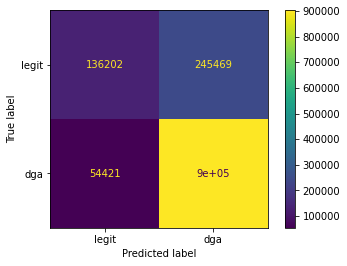

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(LSTMXGBmodel, intermediate_output, Y, display_labels=["legit", "dga"])

In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
LSTMXGBpred=LSTMXGBmodel.predict(intermediate_output)
print(classification_report(Y,LSTMXGBpred))

              precision    recall  f1-score   support

           0       0.71      0.36      0.48    381671
           1       0.79      0.94      0.86    957416

    accuracy                           0.78   1339087
   macro avg       0.75      0.65      0.67   1339087
weighted avg       0.77      0.78      0.75   1339087



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(LSTMXGBpred,Y)
recall=recall_score(LSTMXGBpred,Y)
f1=f1_score(LSTMXGBpred,Y)
accuracy=accuracy_score(LSTMXGBpred,Y)
print(precision,recall,f1,accuracy)

0.9431584598544416 0.7862632176541886 0.8575939749653352 0.776048904962859


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
lxgbppred = LSTMXGBmodel.predict_proba(intermediate_output)[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(Y,lxgbppred)
auc = metrics.roc_auc_score(Y,lxgbppred)

In [ ]:
print(auc)

0.6417319364421444


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(LSTMXGBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
recall=recall_score(LSTMXGBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
f1=f1_score(LSTMXGBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
accuracy=accuracy_score(LSTMXGBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
print(precision,recall,f1,accuracy)

0.9930671649129708 0.9581422562383377 0.975292148214918 0.9852165035827105


#### LSTM+RF

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/BLSTM+RFmodel.sav'
LSTMRFmodel = pickle.load(open(filename, 'rb'))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


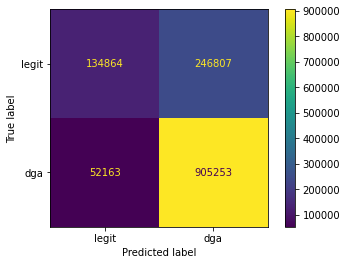

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(LSTMRFmodel, intermediate_output, Y, display_labels=["legit", "dga"])

In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
LSTMRFpred=LSTMRFmodel.predict(intermediate_output)
print(classification_report(Y,LSTMRFpred))

              precision    recall  f1-score   support

           0       0.72      0.35      0.47    381671
           1       0.79      0.95      0.86    957416

    accuracy                           0.78   1339087
   macro avg       0.75      0.65      0.67   1339087
weighted avg       0.77      0.78      0.75   1339087



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(LSTMRFpred,Y)
recall=recall_score(LSTMRFpred,Y)
f1=f1_score(LSTMRFpred,Y)
accuracy=accuracy_score(LSTMRFpred,Y)
print(precision,recall,f1,accuracy)

0.94551689129908 0.7857689703661268 0.8582728601794948 0.7767359402339057


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

lrfppred = LSTMRFmodel.predict_proba(intermediate_output)[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(Y,lrfppred)
auc = metrics.roc_auc_score(Y,lrfppred)

In [ ]:
print(auc)

0.624930141442295


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(LSTMRFmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
recall=recall_score(LSTMRFmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
f1=f1_score(LSTMRFmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
accuracy=accuracy_score(LSTMRFmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
print(precision,recall,f1,accuracy)

0.9927557609728914 0.9618190912483228 0.9770425960053392 0.9862927613837738


#### LSTM+NB

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/BLSTM+NBmodel.sav'
LSTMNBmodel = pickle.load(open(filename, 'rb'))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


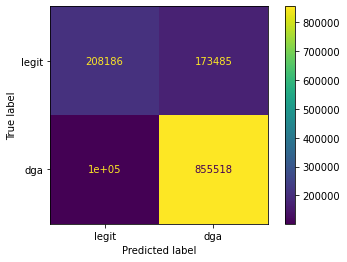

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(LSTMNBmodel, intermediate_output, Y, display_labels=["legit", "dga"])

In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
LSTMNBpred=LSTMNBmodel.predict(intermediate_output)
print(classification_report(Y,LSTMNBpred))

              precision    recall  f1-score   support

           0       0.67      0.55      0.60    381671
           1       0.83      0.89      0.86    957416

    accuracy                           0.79   1339087
   macro avg       0.75      0.72      0.73   1339087
weighted avg       0.79      0.79      0.79   1339087



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(LSTMNBpred,Y)
recall=recall_score(LSTMNBpred,Y)
f1=f1_score(LSTMNBpred,Y)
accuracy=accuracy_score(LSTMNBpred,Y)
print(precision,recall,f1,accuracy)

0.8935697753118812 0.8314047675274028 0.8613671133834302 0.7943501803840975


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

lnbppred = LSTMNBmodel.predict_proba(intermediate_output)[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(Y,lnbppred)
auc = metrics.roc_auc_score(Y,lnbppred)

In [ ]:
print(auc)

0.8027170975451786


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(LSTMNBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
recall=recall_score(LSTMNBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
f1=f1_score(LSTMNBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
accuracy=accuracy_score(LSTMNBmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
print(precision,recall,f1,accuracy)

0.9796358212869177 0.9541456484260264 0.9667227352860307 0.9801843362354573


#### LSTM+LR

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/BLSTM+LRmodel.sav'
LSTMLRmodel = pickle.load(open(filename, 'rb'))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


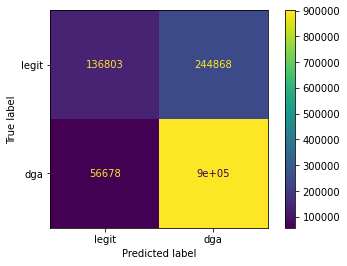

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(LSTMLRmodel, intermediate_output, Y, display_labels=["legit", "dga"])

In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
LSTMLRpred=LSTMLRmodel.predict(intermediate_output)
print(classification_report(Y,LSTMLRpred))

              precision    recall  f1-score   support

           0       0.71      0.36      0.48    381671
           1       0.79      0.94      0.86    957416

    accuracy                           0.77   1339087
   macro avg       0.75      0.65      0.67   1339087
weighted avg       0.76      0.77      0.75   1339087



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(LSTMLRpred,Y)
recall=recall_score(LSTMLRpred,Y)
f1=f1_score(LSTMLRpred,Y)
accuracy=accuracy_score(LSTMLRpred,Y)
print(precision,recall,f1,accuracy)

0.9408010728878565 0.7862546110966597 0.8566130073770033 0.7748122414749751


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

llrppred = LSTMLRmodel.predict_proba(intermediate_output)[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(Y,llrppred)
auc = metrics.roc_auc_score(Y,llrppred)

In [ ]:
print(auc)

0.6034633863905804


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(LSTMLRmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
recall=recall_score(LSTMLRmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
f1=f1_score(LSTMLRmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
accuracy=accuracy_score(LSTMLRmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
print(precision,recall,f1,accuracy)

0.9930179958698003 0.9581705754906457 0.9752831054270927 0.9852116881115648


#### LSTM+ET

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/BLSTM+ETmodel.sav'
LSTMETmodel = pickle.load(open(filename, 'rb'))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


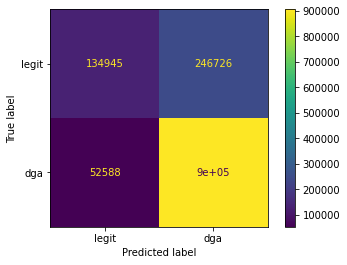

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(LSTMETmodel, intermediate_output, Y, display_labels=["legit", "dga"])

In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
LSTMETpred=LSTMETmodel.predict(intermediate_output)
print(classification_report(Y,LSTMETpred))

              precision    recall  f1-score   support

           0       0.72      0.35      0.47    381671
           1       0.79      0.95      0.86    957416

    accuracy                           0.78   1339087
   macro avg       0.75      0.65      0.67   1339087
weighted avg       0.77      0.78      0.75   1339087



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(LSTMETpred,Y)
recall=recall_score(LSTMETpred,Y)
f1=f1_score(LSTMETpred,Y)
accuracy=accuracy_score(LSTMETpred,Y)
print(precision,recall,f1,accuracy)

0.9450729881263735 0.7857451756496004 0.8580757431352747 0.7764790487847317


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

letppred = LSTMETmodel.predict_proba(intermediate_output)[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(Y,letppred)
auc = metrics.roc_auc_score(Y,letppred)

In [ ]:
print(auc)

0.6187121456671606


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(LSTMETmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
recall=recall_score(LSTMETmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
f1=f1_score(LSTMETmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
accuracy=accuracy_score(LSTMETmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
print(precision,recall,f1,accuracy)

0.9924689415543974 0.961564112743152 0.9767721330117993 0.9861314431003929


#### LSTM+DT

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/BLSTM+DTmodel.sav'
LSTMDTmodel = pickle.load(open(filename, 'rb'))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


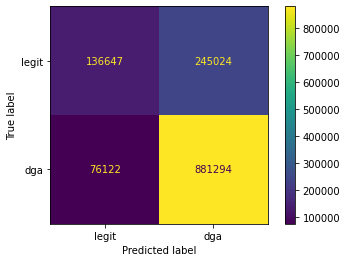

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(LSTMDTmodel, intermediate_output, Y, display_labels=["legit", "dga"])

In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
LSTMDTpred=LSTMDTmodel.predict(intermediate_output)
print(classification_report(Y,LSTMDTpred))

              precision    recall  f1-score   support

           0       0.64      0.36      0.46    381671
           1       0.78      0.92      0.85    957416

    accuracy                           0.76   1339087
   macro avg       0.71      0.64      0.65   1339087
weighted avg       0.74      0.76      0.74   1339087



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(LSTMDTpred,Y)
recall=recall_score(LSTMDTpred,Y)
f1=f1_score(LSTMDTpred,Y)
accuracy=accuracy_score(LSTMDTpred,Y)
print(precision,recall,f1,accuracy)

0.9204922416170191 0.7824557540588004 0.8458795604429357 0.7601754030918081


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

ldtppred = LSTMDTmodel.predict_proba(intermediate_output)[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(Y,ldtppred)
auc = metrics.roc_auc_score(Y,ldtppred)

In [ ]:
print(auc)

0.6392616292902034


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(LSTMDTmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
recall=recall_score(LSTMDTmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
f1=f1_score(LSTMDTmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
accuracy=accuracy_score(LSTMDTmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
print(precision,recall,f1,accuracy)

0.9794309502737076 0.9538699739820269 0.9664814859739776 0.9800398721010863


#### LSTM+AB

In [ ]:
import pickle
# load the model from disk
filename = '/content/drive/My Drive/Colab Notebooks/BLSTM+ABmodel.sav'
LSTMABmodel = pickle.load(open(filename, 'rb'))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


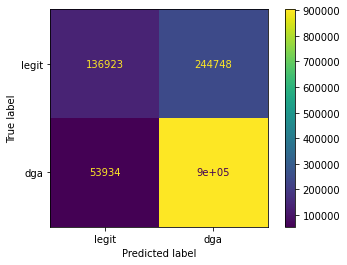

In [ ]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(LSTMABmodel, intermediate_output, Y, display_labels=["legit", "dga"])

In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
LSTMABpred=LSTMABmodel.predict(intermediate_output)
print(classification_report(Y,LSTMABpred))

              precision    recall  f1-score   support

           0       0.72      0.36      0.48    381671
           1       0.79      0.94      0.86    957416

    accuracy                           0.78   1339087
   macro avg       0.75      0.65      0.67   1339087
weighted avg       0.77      0.78      0.75   1339087



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(LSTMABpred,Y)
recall=recall_score(LSTMABpred,Y)
f1=f1_score(LSTMABpred,Y)
accuracy=accuracy_score(LSTMABpred,Y)
print(precision,recall,f1,accuracy)

0.9436671206664605 0.7868475828013551 0.858151845086971 0.776951012144842


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

labppred = LSTMABmodel.predict_proba(intermediate_output)[::,1]

In [ ]:
fpr,tpr, _ = metrics.roc_curve(Y,labppred)
auc = metrics.roc_auc_score(Y,labppred)

In [ ]:
print(auc)

0.6116070536308327


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision=precision_score(LSTMABmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
recall=recall_score(LSTMABmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
f1=f1_score(LSTMABmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
accuracy=accuracy_score(LSTMABmodel.predict(intermediate_layer_model.predict(X_test)),y_test)
print(precision,recall,f1,accuracy)

0.9933048152882945 0.9540642439412186 0.9732891699287364 0.9839813352338392
